### Welcome to the [Data-driven Methods for Network-level Coordination of Autonomous Mobility-on-Demand Systems Across Scales](https://rl4amod-itsc24.github.io/) coding tutorial, presented at 27th IEEE ITSC 2024

<img src="figures/gnn-for-amod.png" width="700"/></td> <br/>

Join us in moving the first steps toward the creation of publicly available benchmarks, datasets, and simulators for network-level coordination of MoD systems.

This notebook offers an interactive, hands-on session for benchmarking AMoD controllers across 
- openly accessible simulation platforms across different fidelity levels 
- calibareted scenarios calibrat 
- Implementation of fleet coordination algorithms

### Installation of required packages

In [ ]:
!pip install hydra-core

In [ ]:
!pip install PuLP

In [ ]:
!pip install torch_geometric

In [ ]:
!pip install traci

### Clone the repository

In [ ]:
!git clone https://github.com/StanfordASL/RL4AMOD

In [ ]:
cd RL4AMOD

### 1. The macro environment 

The macro envorinment is based on taxi record data colleted in various city, e.g. New York City, San Francisco, Washignton DC, Shenzhen. In each scenarion, the road network is segmented into stations by clustering junctions such that the travel time within each station is upper-bounded by a given error tolerance. 

In this notebook, we are looking at the nyc brooklyn scenario. It exists of 14 clustered regions with the following demand distribution: 

<img src="figures/demand_profit.png" alt="drawing" style="background-color: white; border: 1px solid black;" width="800"/>


## 2. Baselines

This repository provides a set of baseline policies, that aim to outperform the no-control policy, which serves as the lower bound. 
The simplest of these is the random rebalancing policy. We evaluate its performance against the no-control policy by assessing total profit, calculated as the profit from passengers served minus the cost of rebalancing.

In [ ]:
import importlib
import testing
import warnings
warnings.filterwarnings("ignore")
importlib.reload(testing)

In [ ]:
importlib.reload(testing)
config = {
    "simulator.name": "macro",
    "model.name": "random",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
!pwd
testing.test(config)

It’s no surprise that the random rebalancing policy fails to outperform the no-control policy. As shown in the figure on the right, it tends to relocate many vehicles to low-demand regions, resulting in inefficient rebalancing.

### Implement your own controller

The random rebalancing policy is not able to outperform the no control baseline, so let's implement a policy that does. We can develop a control policy that aims to achieve an equal distribution of vehicles across the network while minimizing rebalancing costs.

In [ ]:
from src.misc.utils import dictsum
from src.algos.reb_flow_solver import solveRebFlow
from src.algos.base import BaseAlgorithm


class EqualDistribution(BaseAlgorithm):
    def __init__(self, **kwargs):
        """
        :param cplexpath: Path to the CPLEX solver.
        """
        self.cplexpath = kwargs.get('cplexpath') #None, for no CPLEX

    def select_action(self, env):
        """
        Implements the Equal Distribution (ED) baseline for rebalancing.
        :param env: The current state of the environment
        :return: The rebalancing action to be taken
        """
        # number of regions in this scenario
        nregions = env.nregion
        
        #determines the desired vehicle distirbutions
        action = [1 / nregions for _ in range(nregions)]
        
        #calculates the desired number of vehicles in each region
        desired_acc = {
            env.region[i]: int(action[i] * dictsum(env.acc, env.time +1))
            for i in range(len(env.region))
        }
        
        #calculated the min-cost rebalancing flow to reach desried distirbution
        reb_action = solveRebFlow(env, desired_acc, self.cplexpath) 
        
        return reb_action

Now we can test this new policy and compare it to the no control baseline: 

In [ ]:
config = {
    "simulator.name": "macro",
    "model.name": "equal_distribution",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
testing.test(config)

While the equal distribution policy significantly boosts profit compared to the no-control baseline, the rebalancing flows still don't align entirely with the demand distribution. (e.g. region 10 and 12)

## 3. RL-based policies 

Although the equal distribution policy already significantly outperforms the no-control baseline, it remains a reactive approach. Instead of relying on a policy that enforces an equal distribution of idle vehicles, we can implement a reinforcement learning (RL) policy that proactively adjusts the distribution based on the current state. 

In this repository, we already provide a pre-trained agent: 

In [ ]:
# from testing import test
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_nyc_brooklyn"
}
testing.test(config)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_nyc_brooklyn",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 4,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True
}
testing.multi_test(config)

In [ ]:
# With not changing x
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": "equal_distribution",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
testing.test(config)

In [ ]:
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": "random",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
testing.test(config)

### Final comparison

<img src="figures/comparison_final.png" alt="drawing" style="background-color: white; border: 1px solid black;" width="650"/>

## 4. Implement an RL agent

Generally policy takes the current state as input and outputs the next action $\pi(a_t | s_t)$:

<img src="figures/NN_Actor.png" alt="drawing" style="background-color: white; border: 1px solid black;" width="200"/>

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch.distributions import Dirichlet

class Actor(nn.Module):
    """
    Actor \pi(a_t | s_t) parametrizing the concentration parameters of a Dirichlet Policy.
    """

    def __init__(self, in_channels, act_dim, hidden_size=32):
        super().__init__()
        """
        in_channels: state dimension
        act_dim: action dimension
        """
        self.lin1 = nn.Linear(in_channels, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, act_dim)
    
    def forward(self, state):
        x = F.relu(self.lin1(state))
        x = F.relu(self.lin2(x))
        x = F.softplus(self.lin3(x))
    
        concentration = x.squeeze(-1)
        m = Dirichlet(concentration + 1e-20)
        action = m.sample()

        return action

In [ ]:
import torch
import matplotlib.pyplot as plt
'''
The state consits of 14 regions/nodes with 13 node features each
'''
state = torch.ones(14, 13) 

state = state.flatten() #MLP expects a vector input

actor = Actor(in_channels=14*13, act_dim=14)

action = actor(state)

In [ ]:
plt.bar(range(14), action.detach().numpy())
plt.show()

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch.distributions import Dirichlet
from torch_geometric.nn import GCNConv


class GNNActor(nn.Module):
    """
    Actor \pi(a_t | s_t) parametrizing the concentration parameters of a Dirichlet Policy.
    """

    def __init__(self, in_channels, hidden_size=32, act_dim=6):
        super().__init__()
        self.in_channels = in_channels
        self.act_dim = act_dim
        self.conv1 = GCNConv(in_channels, in_channels)
        self.lin1 = nn.Linear(in_channels, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, 1)

    def forward(self, state, edge_index):
        out = F.relu(self.conv1(state, edge_index))
        x = out + state
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.softplus(self.lin3(x))
        
        concentration = x.squeeze(-1)
        m = Dirichlet(concentration + 1e-20)
        action = m.sample()
           
        return action
    

In [ ]:
state = torch.ones(14, 13) 
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13],
                           [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12]])

actor = GNNActor(in_channels=13)

action = actor(state, edge_index)

plt.bar(range(14), action.detach().numpy())
plt.show()

## Train an RL agent

### Portion based / Constant Vehicle Count

In [1]:
import importlib
import testing
import warnings
warnings.filterwarnings("ignore")
importlib.reload(testing)

<module 'testing' from '/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Dynamic-Routing-with-Competition/testing.py'>

In [2]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_portion_2",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
train(config)

Episode 50 | Reward: 14543.80 | ServedDemand: 24671.80 | Reb. Cost: 10128.00: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Testing model sac on multi_macro environment


Test Episode 2 | Reward: 24596.93 | ServedDemand: 29720.93 | Reb. Cost: 5124.00: 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

Mean Episode Profit ($):  24124.864743881237
Mean Episode Served Demand- Proit($):  29277.86474388124
Mean Episode Rebalancing Cost($):  5153.0
Testing model equal_distribution on multi_macro environment


Test Episode 2 | Reward: 24641.51 | ServedDemand: 29785.51 | Reb. Cost: 5144.00: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

Mean Episode Profit ($):  24136.931904715995
Mean Episode Served Demand- Proit($):  29295.931904715995
Mean Episode Rebalancing Cost($):  5159.0
Testing model random on multi_macro environment


Test Episode 2 | Reward: 13240.35 | ServedDemand: 24488.35 | Reb. Cost: 11248.00: 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]
Test Episode 1 | Reward: 11231.33 | ServedDemand: 11231.33 | Reb. Cost: 0.00:  10%|█         | 1/10 [00:00<00:00,  9.26it/s]

Mean Episode Profit ($):  11110.254550191832
Mean Episode Served Demand- Proit($):  22834.25455019183
Mean Episode Rebalancing Cost($):  11724.0
No control performance not found. Calculating (this happens only the first time on a new environment)...


Test Episode 10 | Reward: 12428.11 | ServedDemand: 12428.11 | Reb. Cost: 0.00: 100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


No control performance calculated. Saving in ./src/envs/data/multi_macro/nyc_brooklyn_no_control_performance.json...
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Dynamic-Routing-with-Competition


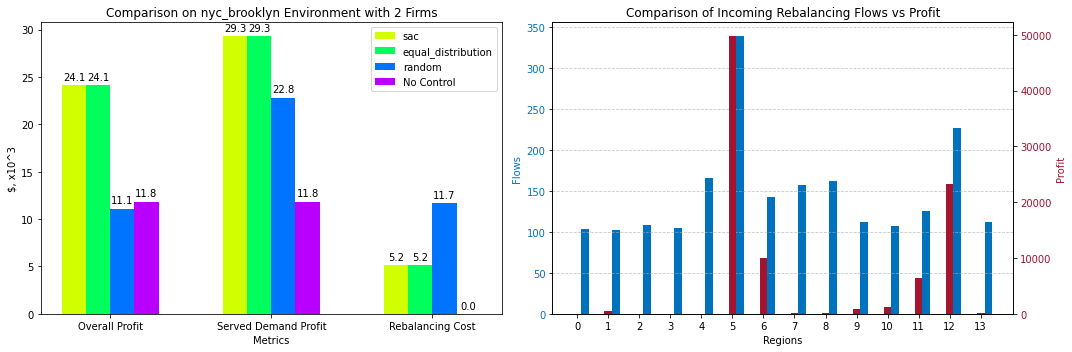

In [3]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 2,
    "model.checkpoint_path": "SAC_portion_2",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
testing.multi_test(config)

In [4]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_portion_3",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 3,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
train(config)

Episode 50 | Reward: 1939.62 | ServedDemand: 10295.62 | Reb. Cost: 8356.00: 100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Testing model sac on multi_macro environment


Test Episode 10 | Reward: 12541.12 | ServedDemand: 16441.12 | Reb. Cost: 3900.00: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  12184.366303030303
Mean Episode Served Demand- Proit($):  16257.966303030302
Mean Episode Rebalancing Cost($):  4073.6
Testing model equal_distribution on multi_macro environment


Test Episode 10 | Reward: 12129.97 | ServedDemand: 15939.97 | Reb. Cost: 3810.00: 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  11822.996056277056
Mean Episode Served Demand- Proit($):  15692.396056277057
Mean Episode Rebalancing Cost($):  3869.4
Testing model random on multi_macro environment


Test Episode 10 | Reward: 745.68 | ServedDemand: 9571.68 | Reb. Cost: 8826.00: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]
Test Episode 1 | Reward: 4654.52 | ServedDemand: 4654.52 | Reb. Cost: 0.00:  10%|█         | 1/10 [00:00<00:01,  8.66it/s]

Mean Episode Profit ($):  3428.3823051948057
Mean Episode Served Demand- Proit($):  11654.782305194805
Mean Episode Rebalancing Cost($):  8226.4
No control performance not found. Calculating (this happens only the first time on a new environment)...


Test Episode 10 | Reward: 5010.16 | ServedDemand: 5010.16 | Reb. Cost: 0.00: 100%|██████████| 10/10 [00:00<00:00, 10.69it/s]


No control performance calculated. Saving in ./src/envs/data/multi_macro/nyc_brooklyn_no_control_performance.json...
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Dynamic-Routing-with-Competition


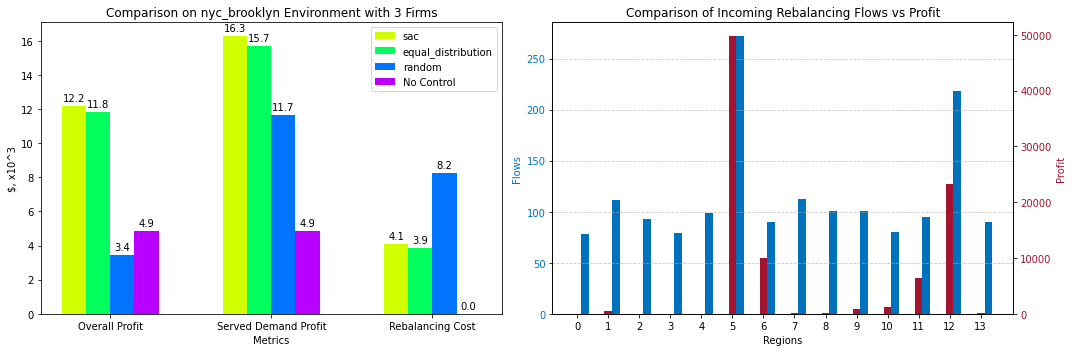

In [5]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_portion_3",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 3,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
testing.multi_test(config)

In [6]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_portion_4",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 4,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
train(config)

Episode 50 | Reward: -395.72 | ServedDemand: 5816.28 | Reb. Cost: 6212.00: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s] 


  0%|          | 0/10 [00:00<?, ?it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Testing model sac on multi_macro environment


Test Episode 10 | Reward: 5080.24 | ServedDemand: 7816.24 | Reb. Cost: 2736.00: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  4932.879931379731
Mean Episode Served Demand- Proit($):  7557.879931379731
Mean Episode Rebalancing Cost($):  2625.0
Testing model equal_distribution on multi_macro environment


Test Episode 10 | Reward: 4830.24 | ServedDemand: 7622.24 | Reb. Cost: 2792.00: 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  4854.976059933716
Mean Episode Served Demand- Proit($):  7448.3760599337165
Mean Episode Rebalancing Cost($):  2593.4
Testing model random on multi_macro environment


Test Episode 10 | Reward: -532.67 | ServedDemand: 5899.33 | Reb. Cost: 6432.00: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s]
Test Episode 2 | Reward: 3838.10 | ServedDemand: 3838.10 | Reb. Cost: 0.00:  20%|██        | 2/10 [00:00<00:00, 12.11it/s]

Mean Episode Profit ($):  -1019.5613398918542
Mean Episode Served Demand- Proit($):  5685.438660108146
Mean Episode Rebalancing Cost($):  6705.0
No control performance not found. Calculating (this happens only the first time on a new environment)...


Test Episode 10 | Reward: 3831.54 | ServedDemand: 3831.54 | Reb. Cost: 0.00: 100%|██████████| 10/10 [00:00<00:00, 12.46it/s]


No control performance calculated. Saving in ./src/envs/data/multi_macro/nyc_brooklyn_no_control_performance.json...
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Dynamic-Routing-with-Competition


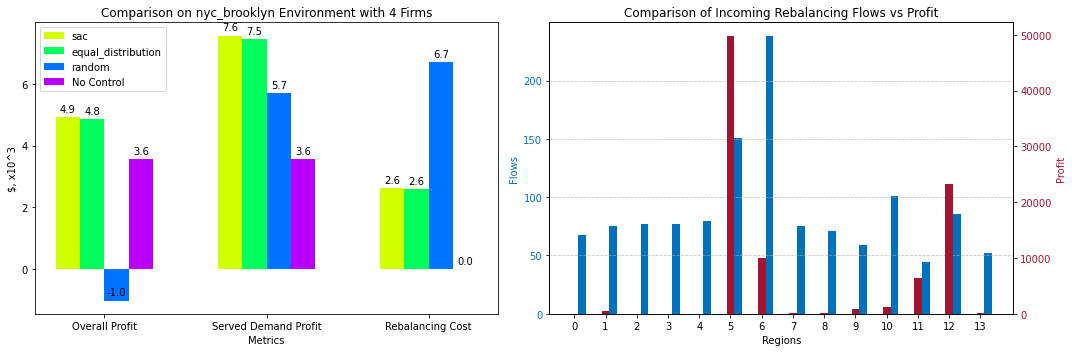

In [7]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_portion_4",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 4,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
testing.multi_test(config)

### Flow based / Constant Vehicle Count

In [14]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_flow_2",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow"  # or portion
}
train(config)

Episode 50 | Reward: 14875.45 | ServedDemand: 25027.45 | Reb. Cost: 10152.00: 100%|██████████| 50/50 [00:38<00:00,  1.28it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Testing model sac on multi_macro environment


Test Episode 10 | Reward: 25240.60 | ServedDemand: 29954.60 | Reb. Cost: 4714.00: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  25220.5488114835
Mean Episode Served Demand- Proit($):  30053.148811483494
Mean Episode Rebalancing Cost($):  4832.6
Testing model equal_distribution on multi_macro environment


Test Episode 10 | Reward: 25184.08 | ServedDemand: 29912.08 | Reb. Cost: 4728.00: 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  25112.71062637107
Mean Episode Served Demand- Proit($):  29921.11062637107
Mean Episode Rebalancing Cost($):  4808.4
Testing model random on multi_macro environment


Test Episode 10 | Reward: 15808.34 | ServedDemand: 25236.34 | Reb. Cost: 9428.00: 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]
Test Episode 2 | Reward: 13640.06 | ServedDemand: 13640.06 | Reb. Cost: 0.00:  20%|██        | 2/10 [00:00<00:00, 10.22it/s]

Mean Episode Profit ($):  13908.337844558127
Mean Episode Served Demand- Proit($):  24407.13784455813
Mean Episode Rebalancing Cost($):  10498.8
No control performance not found. Calculating (this happens only the first time on a new environment)...


Test Episode 10 | Reward: 14044.55 | ServedDemand: 14044.55 | Reb. Cost: 0.00: 100%|██████████| 10/10 [00:00<00:00, 11.23it/s]


No control performance calculated. Saving in ./src/envs/data/multi_macro/nyc_brooklyn_no_control_performance.json...
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Dynamic-Routing-with-Competition


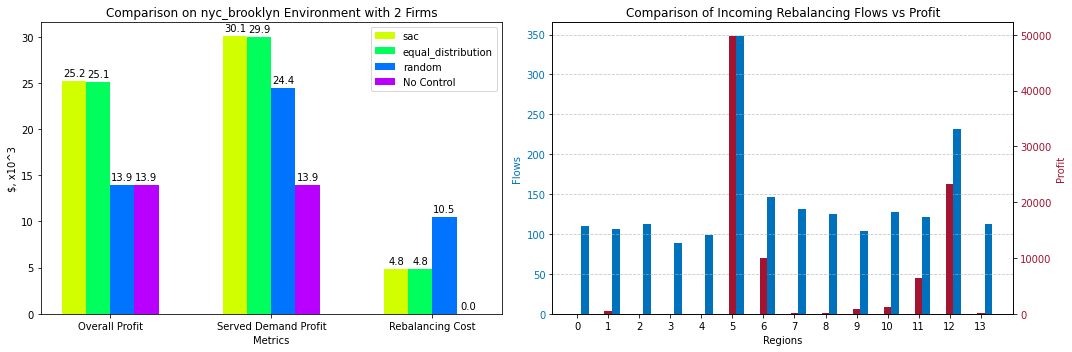

In [16]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_flow_2",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
testing.multi_test(config)

In [17]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_flow_3",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 3,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
train(config)

Episode 50 | Reward: 6646.60 | ServedDemand: 14586.60 | Reb. Cost: 7940.00: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s] 


  0%|          | 0/10 [00:00<?, ?it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Testing model sac on multi_macro environment


Test Episode 10 | Reward: 16779.72 | ServedDemand: 20189.72 | Reb. Cost: 3410.00: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  16723.62449005231
Mean Episode Served Demand- Proit($):  19991.62449005231
Mean Episode Rebalancing Cost($):  3268.0
Testing model equal_distribution on multi_macro environment


Test Episode 10 | Reward: 16408.07 | ServedDemand: 19670.07 | Reb. Cost: 3262.00: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  16372.267714017351
Mean Episode Served Demand- Proit($):  19532.26771401735
Mean Episode Rebalancing Cost($):  3160.0
Testing model random on multi_macro environment


Test Episode 10 | Reward: 9259.95 | ServedDemand: 16103.95 | Reb. Cost: 6844.00: 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]
Test Episode 2 | Reward: 9134.59 | ServedDemand: 9134.59 | Reb. Cost: 0.00:  20%|██        | 2/10 [00:00<00:00, 12.28it/s]

Mean Episode Profit ($):  8548.889507780574
Mean Episode Served Demand- Proit($):  15683.689507780573
Mean Episode Rebalancing Cost($):  7134.8
No control performance not found. Calculating (this happens only the first time on a new environment)...


Test Episode 10 | Reward: 8257.65 | ServedDemand: 8257.65 | Reb. Cost: 0.00: 100%|██████████| 10/10 [00:00<00:00, 11.80it/s]


No control performance calculated. Saving in ./src/envs/data/multi_macro/nyc_brooklyn_no_control_performance.json...
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Dynamic-Routing-with-Competition


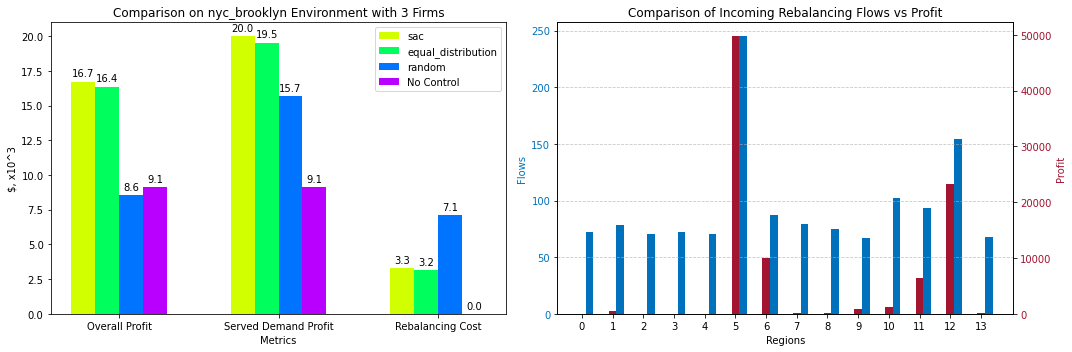

In [18]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_flow_3",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 3,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
testing.multi_test(config)

In [19]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_flow_4",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 4,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
train(config)

Episode 50 | Reward: 5873.92 | ServedDemand: 11317.92 | Reb. Cost: 5444.00: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Testing model sac on multi_macro environment


Test Episode 10 | Reward: 12670.13 | ServedDemand: 14962.13 | Reb. Cost: 2292.00: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  12033.090108787026
Mean Episode Served Demand- Proit($):  14390.890108787027
Mean Episode Rebalancing Cost($):  2357.8
Testing model equal_distribution on multi_macro environment


Test Episode 10 | Reward: 12774.20 | ServedDemand: 15100.20 | Reb. Cost: 2326.00: 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]
  0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  12094.153507298712
Mean Episode Served Demand- Proit($):  14524.953507298711
Mean Episode Rebalancing Cost($):  2430.8
Testing model random on multi_macro environment


Test Episode 10 | Reward: 7013.30 | ServedDemand: 12107.30 | Reb. Cost: 5094.00: 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]
Test Episode 1 | Reward: 7249.71 | ServedDemand: 7249.71 | Reb. Cost: 0.00:   0%|          | 0/10 [00:00<?, ?it/s]

Mean Episode Profit ($):  6556.136075206004
Mean Episode Served Demand- Proit($):  11761.336075206003
Mean Episode Rebalancing Cost($):  5205.2
No control performance not found. Calculating (this happens only the first time on a new environment)...


Test Episode 10 | Reward: 7358.68 | ServedDemand: 7358.68 | Reb. Cost: 0.00: 100%|██████████| 10/10 [00:00<00:00, 10.24it/s]


No control performance calculated. Saving in ./src/envs/data/multi_macro/nyc_brooklyn_no_control_performance.json...
/home/gaby/Documents/UCB/AAM/GIT/sastryrepo/Dynamic-Routing-with-Competition


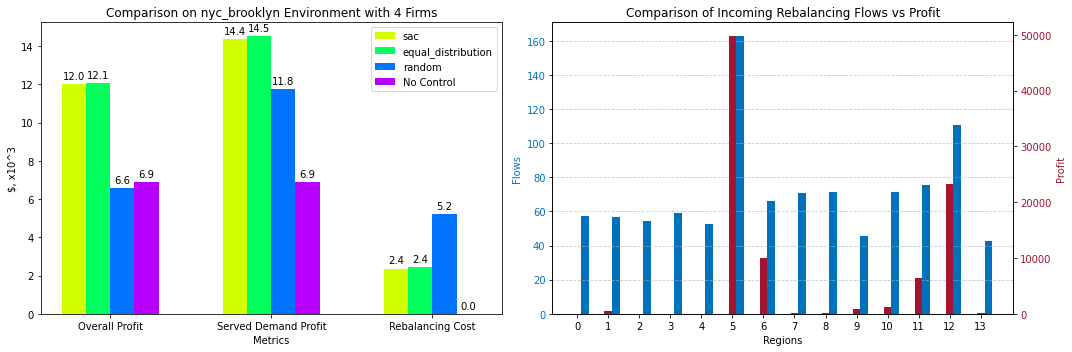

In [20]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_flow_4",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 4,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
testing.multi_test(config)

### Additional: SUMO Environment

The SUMO environment is built around a mesoscopic traffic simulator using the Simulation of Urban MObility (SUMO) framework. The available scenario is based on the city of Luxembourg, utilizing the LuST Scenario (https://github.com/lcodeca/lux), where the traffic demand has been derived from a calibrated trips file. To create a more simplified and abstract representation of the city, the road network has been spatially aggregated into 10 regions, resulting in a coarser graph of the urban landscape.

<img src="figures/lux_net.png" alt="drawing" width="500"/>    <img src="figures/lux_net_aggregated.png" alt="drawing" width="500"/>

In [ ]:
config = {
"simulator.name": "sumo",
"model.name": "mpc",
"simulator.city": "lux",
"model.cplexpath": None, 
"model.test_episodes": 1,
}
test(config)
